# Hidden Markov modeling

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import scipy
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist

pyro.enable_validation(True)

In [3]:
import os
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.contrib.autoguide import AutoDiagonalNormal

#smoke_test = ('CI' in os.environ)
#assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation()
pyro.set_rng_seed(0)

### Define templates

In [43]:
# template functions for classes A (spot) and B (no spot)
def classA(height, width, background, N=9):
    loc = torch.ones(2) * (N-1)/2
    precision = torch.ones(2) / width**2
    x, y = torch.meshgrid(torch.arange(N), torch.arange(N))
    pos = torch.stack((x, y), dim=2).float()
    rv = dist.MultivariateNormal(loc, precision_matrix=torch.diag(precision))
    gaussian_spot = torch.exp(rv.expand([N,N]).log_prob(pos)) * 2 * np.pi / precision.sqrt().prod()
    return height * gaussian_spot + background

def classB(background, N=9):
    return torch.ones(N,N)*background

### Generate data

In [ ]:
def hmm_model(data, data_dim, hidden_dim=6):
    with pyro.plate("hidden_state", hidden_dim):
        transition = pyro.sample("transition", dist.Dirichlet(0.5 * torch.ones(hidden_dim)))
        emission = pyro.sample("emission", dist.Dirichlet(0.5 * torch.ones(data_dim)))

    x = 0  # initial state
    for t, y in pyro.markov(enumerate(data)):
        x = pyro.sample("x_{}".format(t), dist.Categorical(transition[x]),
                        infer={"enumerate": "parallel"})
        pyro.sample("y_{}".format(t), dist.Categorical(emission[x]), obs=y)
        print("x_{}.shape = {}".format(t, x.shape))

# We'll reuse the same guide and elbo.
elbo.loss(hmm_model, hmm_guide, data, data_dim=data_dim);

In [4]:
from models import generate

K = 2  # Fixed number of components.
D = 9  # size of the square images in one dimension
N = 1000
h_true = 200. 
w_true = 1.7
b_true = 400.
#noise_true = 20.
pi_true = torch.tensor([0.4, 0.6])

data, states = generate(h_true, w_true, b_true, pi_true, D, K, N)

print("Spots #: {}".format(states.cpu().numpy().sum()))
print("Background level = {}".format(b_true))
print("2D-Gaussian height = {}; width = {}".format(h_true, w_true))
#print("Normal noise: {}".format(noise_true))

Spots #: 1
Background level = 400.0
2D-Gaussian height = 200.0; width = 1.7


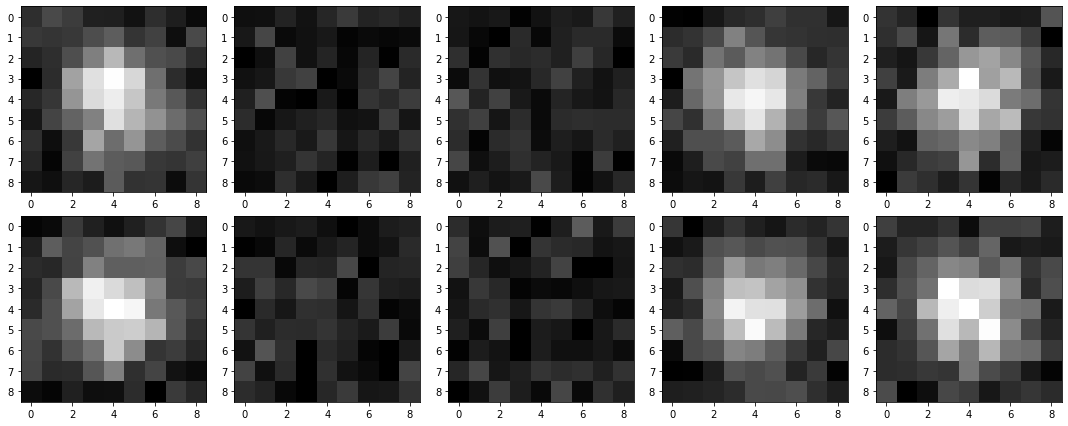

In [5]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(data[i,:,:].cpu(), cmap='gray', vmin=np.percentile(data.cpu().numpy(), 5), vmax=np.percentile(data.cpu().numpy(), 99))

plt.tight_layout()
plt.show()

### Hidden Markov Model

In [ ]:
def generate(height, width, background, N, K, sample_size):
    # class templates
    locs = torch.zeros(K,N,N)
    locs[0,:,:] = classB(background,N)
    locs[1,:,:] = classA(height, width, background,N)
    transition = torch.tensor([[0.3, 0.7], [0.3, 0.7]])
    z = 0
    data = torch.zeros(sample_size,N,N)
    #data = pyro.sample("data_{}".format(t), dist.Normal(locs[z,:,:], 20.).to_event(2))
    for t in range(sample_size):
        # hidden states; nospot p(0) = 0.4, spot p(1) = 0.6
        z = pyro.sample("z_{}".format(t), dist.Categorical(transition[z]))
        print(z)
        # add normal noise (std = 20) to template images
        data[t,:,:] = pyro.sample("data_{}".format(t), dist.Normal(locs[z,:,:], 20.).to_event(2))
    return data, z

In [98]:
pyro.clear_param_store()

#@config_enumerate
def hmm_model(data, K):
    sample_size, N, _ = data.shape
    # prior distributions
    #weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(K)))
    height = pyro.sample('height', dist.Uniform(0., 300.))
    background = pyro.sample('background', dist.Uniform(0., 1000.))
    # class templates
    locs = torch.zeros(K,N,N)
    locs[0,:,:] = classB(background)
    locs[1,:,:] = classA(height, 2, background)
    with pyro.plate("hidden_state", K):
        transition = pyro.sample("transition", dist.Dirichlet(0.5 * torch.ones(K)))

    #with pyro.plate("sample_size", sample_size):
    z = 0
    for t in range(sample_size):
        # hidden states
        z = pyro.sample("z_{}".format(t), dist.Categorical(transition[z]), infer={"enumerate": "parallel"})
        # likelihood / conditioning on data
        pyro.sample("obs_{}".format(t), dist.Normal(locs[z,:,:], 20.).to_event(2), obs=data[t])
        
def guide(data, K):
    sample_size, N, _ = data.shape
    # posterior approximations
    concentrations = pyro.param("concentrations", torch.ones(K,K) * 0.5)
    #weights = pyro.sample("weights", dist.Dirichlet(concentrations))
    with pyro.plate("hidden_state", K):
        transition = pyro.sample("transition", dist.Dirichlet(concentrations))
    
    height_loc = pyro.param("height_loc", torch.tensor(100.))
    height_scale = pyro.param("height_scale", torch.tensor(20.), constraint=constraints.positive)
    height = pyro.sample("height", dist.Normal(height_loc, height_scale)) # true distribution
    
    background_loc = pyro.param("background_loc", torch.tensor(360.))
    background_scale = pyro.param("background_scale", torch.tensor(50.), constraint=constraints.positive)
    background = pyro.sample('background', dist.Normal(background_loc, background_scale))

In [107]:
pyro.param("concentrations")

tensor([[4.0911, 3.4664],
        [2.6397, 1.9334]], requires_grad=True)

In [99]:
optim = pyro.optim.Adam({'lr': 0.07, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(hmm_model, guide, optim, loss=elbo)

In [100]:
losses = []
for i in range(1000):
    loss = svi.step(data, K)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

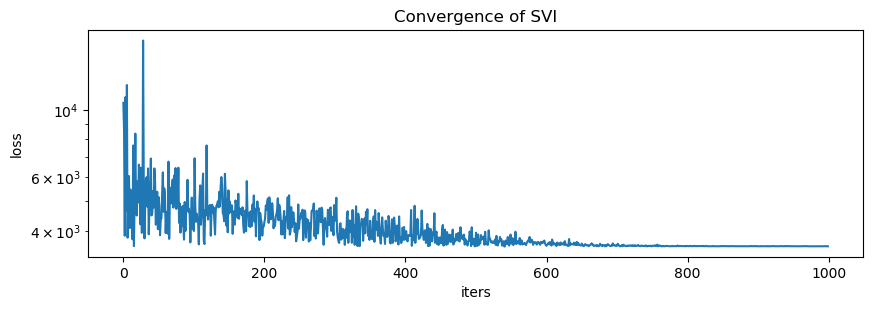

In [101]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

### Class membership probabilities

In [124]:
@config_enumerate
def full_guide(data, K):
    sample_size, N, _ = data.shape
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        guide(data, K)
    # Local variables.
    z = 0
    for t in range(sample_size):
        # hidden states
        z = pyro.sample("z_{}".format(t), dist.Categorical(transition[z]), infer={"enumerate": "parallel"})
        # likelihood / conditioning on data
        #pyro.sample("obs_{}".format(t), dist.Normal(locs[z,:,:], 20.).to_event(2), obs=data[t])
        
    with pyro.plate("sample_size", sample_size):
        z_probs = pyro.param("z_probs", torch.ones(sample_size, K) / K, constraint=constraints.simplex)
        pyro.sample("z", dist.Categorical(z_probs))

In [125]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO()
svi = SVI(model, full_guide, optim, loss=elbo)

losses = []
for i in range(200):
    loss = svi.step(data, K)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

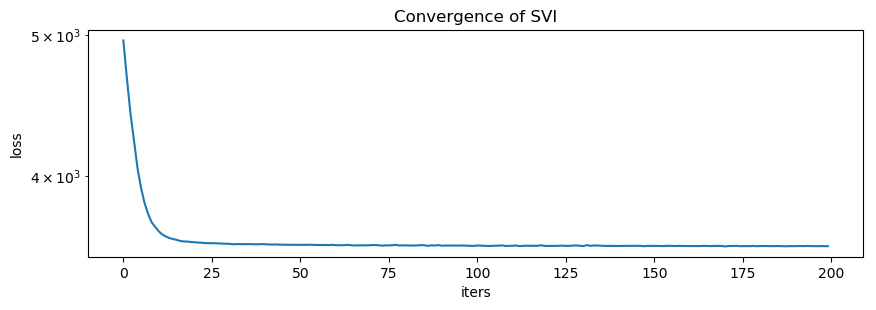

In [126]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

Probabilities for the correct class


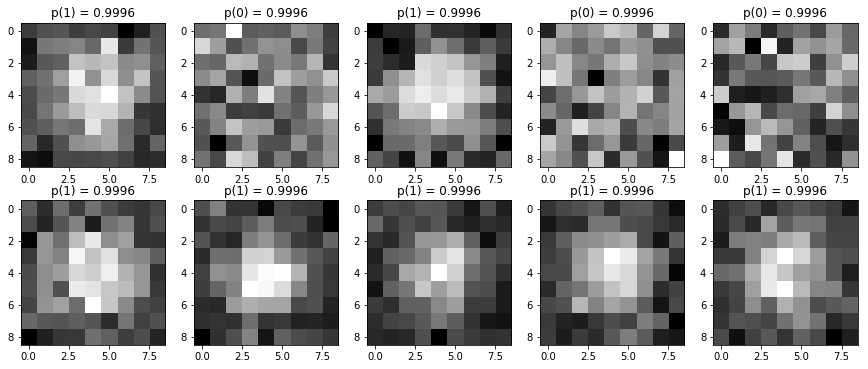

In [127]:
print("Probabilities for the correct class")
z_p = pyro.param('z_probs')
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title("p({}) = {:.4f}".format(zs[i], z_p[i,zs[i]]))
    plt.imshow(data[i,:,:], cmap='gray')
plt.show()

### Inferred height and background

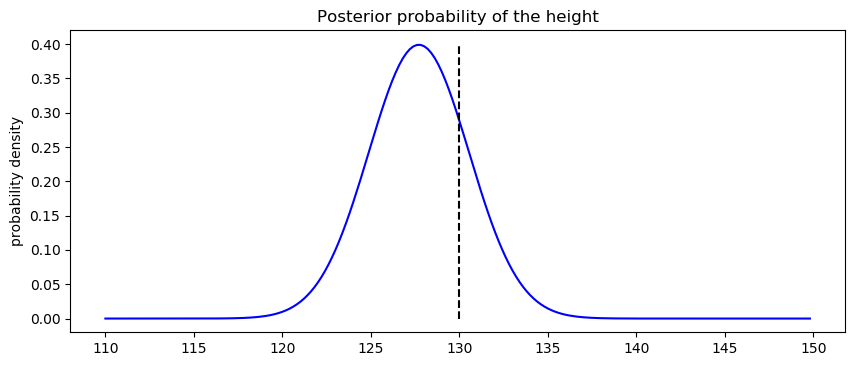

In [102]:
X = np.arange(110,150,0.2)
Y = scipy.stats.norm.pdf((X - pyro.param("height_loc").item()) / pyro.param("height_scale").item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y, 'b-')
plt.plot([130, 130], [0., 0.4], 'k--')
#pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title("Posterior probability of the height")
plt.ylabel("probability density");

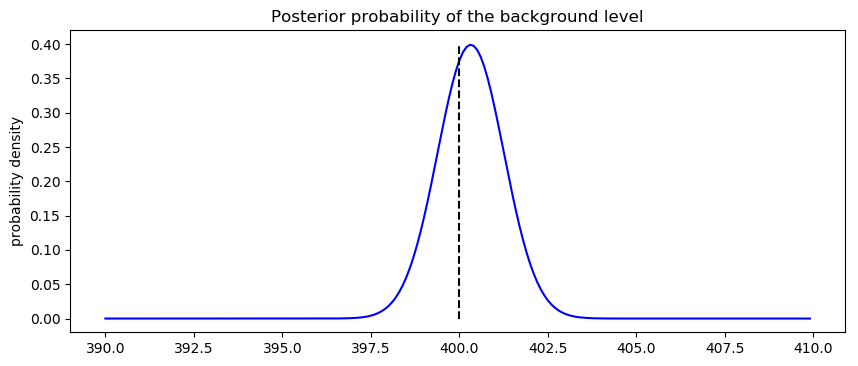

In [103]:
X = np.arange(390,410,0.1)
Y = scipy.stats.norm.pdf((X - pyro.param("background_loc").item()) / pyro.param("background_scale").item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y, 'b-')
plt.plot([400., 400.], [0., 0.4], 'k--')
#pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Posterior probability of the background level')
plt.ylabel('probability density');

In [114]:
pyro.param("transition")[0].data.numpy()

KeyError: 'transition'

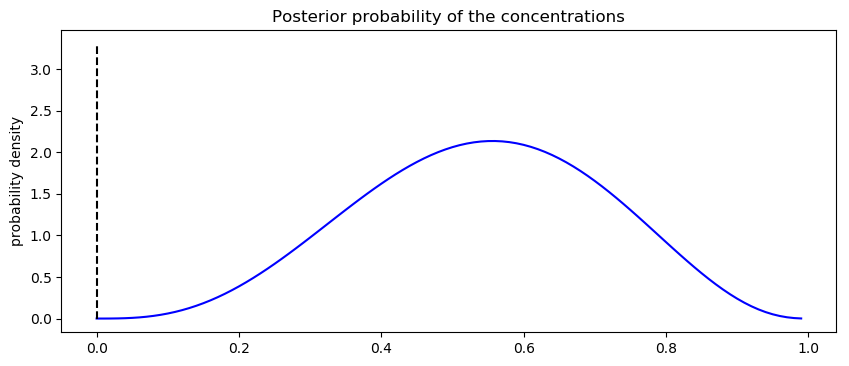

In [115]:
X = np.zeros((100,2))
X[:,0] = np.arange(0,1,0.01)
X[:,1] = 1 - X[:,0]
pi = 1 - torch.mean(zs.float())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X[:,0], [scipy.stats.dirichlet.pdf(X[i], pyro.param("concentrations")[0].data.numpy()) for i in range(100)], 'b-')
plt.plot([pi, pi], [0., 3.3], 'k--')
plt.title('Posterior probability of the concentrations')
plt.ylabel('probability density');

In [40]:
def hmm_model(data, data_dim, hidden_dim=6):
    with pyro.plate("hidden_state", hidden_dim):
        transition = pyro.sample("transition", dist.Dirichlet(0.5 * torch.ones(hidden_dim)))
        emission = pyro.sample("emission", dist.Dirichlet(0.5 * torch.ones(data_dim)))

    x = 0  # initial state
    for t, y in pyro.markov(enumerate(data)):
        x = pyro.sample("x_{}".format(t), dist.Categorical(transition[x]),
                        infer={"enumerate": "parallel"})
        pyro.sample("y_{}".format(t), dist.Categorical(emission[x]), obs=y)
        print("x_{}.shape = {}".format(t, x.shape))

# We'll reuse the same guide and elbo.
elbo.loss(hmm_model, hmm_guide, data, data_dim=data_dim);

x_0.shape = torch.Size([6, 1])
x_1.shape = torch.Size([6, 1, 1])
x_2.shape = torch.Size([6, 1])
x_3.shape = torch.Size([6, 1, 1])
x_4.shape = torch.Size([6, 1])
x_5.shape = torch.Size([6, 1, 1])
x_6.shape = torch.Size([6, 1])
x_7.shape = torch.Size([6, 1, 1])
x_8.shape = torch.Size([6, 1])
x_9.shape = torch.Size([6, 1, 1])


In [41]:
def model_0(sequences, lengths, args, batch_size=None, include_prior=True):
    assert not torch._C._get_tracing_state()
    num_sequences, max_length, data_dim = sequences.shape
    with poutine.mask(mask=include_prior):
        # Our prior on transition probabilities will be:
        # stay in the same state with 90% probability; uniformly jump to another
        # state with 10% probability.
        probs_x = pyro.sample("probs_x",
                              dist.Dirichlet(0.9 * torch.eye(args.hidden_dim) + 0.1)
                                  .to_event(1))
        # We put a weak prior on the conditional probability of a tone sounding.
        # We know that on average about 4 of 88 tones are active, so we'll set a
        # rough weak prior of 10% of the notes being active at any one time.
        probs_y = pyro.sample("probs_y",
                              dist.Beta(0.1, 0.9)
                                  .expand([args.hidden_dim, data_dim])
                                  .to_event(2))
    # In this first model we'll sequentially iterate over sequences in a
    # minibatch; this will make it easy to reason about tensor shapes.
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    for i in pyro.plate("sequences", len(sequences), batch_size):
        length = lengths[i]
        sequence = sequences[i, :length]
        x = 0
        for t in pyro.markov(range(length)):
            # On the next line, we'll overwrite the value of x with an updated
            # value. If we wanted to record all x values, we could instead
            # write x[t] = pyro.sample(...x[t-1]...).
            x = pyro.sample("x_{}_{}".format(i, t), dist.Categorical(probs_x[x]),
                            infer={"enumerate": "parallel"})
            with tones_plate:
                pyro.sample("y_{}_{}".format(i, t), dist.Bernoulli(probs_y[x.squeeze(-1)]),
                            obs=sequence[t])